# Final Sweep — Imagination Hyperparameters

Analyze sweep `8finalsweep/finalsweep` to understand how imagination-related hyperparameters impact evaluation reward across five DMControl tasks.

In [1]:
from pathlib import Path
import sys

NOTEBOOK_DIR = Path().resolve()
REPO_ROOT = NOTEBOOK_DIR.parent.parent
if not (REPO_ROOT / "analysis" / "tools").exists():
    raise RuntimeError("Unable to locate analysis/tools package from notebook directory")
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
import pandas as pd

from IPython.display import Image
from analysis.tools import aggregations, baselines, naming, plotting, selection, wandb_io, paths
from analysis.tools.paths import ensure_dir

In [3]:
NOTEBOOK_STEM = "final_imagination_sweep"
SWEEP_ROOT = Path("../../sweep_list/midterm_sweep/8finalsweep/finalsweep").resolve()
SWEEP_ID = SWEEP_ROOT.joinpath("id.txt").read_text().strip()
WANDB_PROJECT = SWEEP_ROOT.joinpath("project.txt").read_text().strip()
WANDB_ENTITY = "thomasevers9"
HISTORY_KEYS = [
    "eval/episode_reward",
    "eval/step",
    "train/step",
    "global_step",
    "total_env_steps",
    "step",
    "_step",
]
STEP_KEYS = ["eval/step", "train/step", "global_step", "total_env_steps", "step", "_step"]
METRIC_KEY = "eval/episode_reward"
STEP_TARGET = 100_000
BASELINE_LABEL = "tdmpc2"
ENCODER_VARIANT_COLUMN = "enc_lr_scale"
ENCODER_OPTIMAL_SCALE = 0.3
ENCODING_SPECS = {
    "color": {"column": "num_rollouts", "label": "num_rollouts"},
    "dash": {"column": "entropy_coef", "label": "entropy_coef"},
    "width": {"column": "utd_ratio", "label": "utd_ratio", "values": {1: 2.5, 2: 4.0}},
}
RESULTS_DIR = paths.notebook_results_dir(NOTEBOOK_STEM)
RESULTS_DIR

PosixPath('/home/thoma/projects/auxiliary_targets/tdmpc2/analysis/results/final_imagination_sweep')

In [4]:
runs_payload, manifest, data_source = wandb_io.fetch_sweep_runs(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    sweep_id=SWEEP_ID,
    history_keys=HISTORY_KEYS,
    use_cache=True,
    force_refresh=False,
)
print(f"Loaded {manifest['run_count']} runs from {data_source}")

Loaded 360 runs from cache


In [5]:
CONFIG_TO_COLUMNS = {
    "task": "task",
    "seed": "seed",
    "enc_lr_scale": "enc_lr_scale",
    "num_rollouts": "num_rollouts",
    "entropy_coef": "entropy_coef",
    "utd_ratio": "utd_ratio",
    "imagination_horizon": "imagination_horizon",
    "obs": "obs",
}

runs_df = aggregations.runs_history_to_frame(
    runs_payload,
    metric_key=METRIC_KEY,
    step_keys=STEP_KEYS,
    config_to_columns=CONFIG_TO_COLUMNS,
)
runs_df["task_baseline"] = runs_df["task"].map(naming.wandb_task_to_baseline)
runs_df.head()

,task,seed,enc_lr_scale,num_rollouts,entropy_coef,utd_ratio,imagination_horizon,obs,run_id,step,eval/episode_reward,task_baseline
0,cartpole-swingup-sparse,203,0.3,16,0.0001,1,1,state,034sx404,0,0.000000,cartpole-swingup-sparse
1,cartpole-swingup-sparse,203,0.3,16,0.0001,1,1,state,034sx404,10000,0.000000,cartpole-swingup-sparse
2,cartpole-swingup-sparse,203,0.3,16,0.0001,1,1,state,034sx404,20000,0.000000,cartpole-swingup-sparse
3,cartpole-swingup-sparse,203,0.3,16,0.0001,1,1,state,034sx404,30000,4.600000,cartpole-swingup-sparse
4,cartpole-swingup-sparse,203,0.3,16,0.0001,1,1,state,034sx404,40000,63.200001,cartpole-swingup-sparse


In [6]:
obs_modes = sorted(runs_df["obs"].unique())
if not obs_modes:
    raise ValueError("No observation modalities detected in runs_df")
if len(obs_modes) > 1:
    raise ValueError(
        f"Multiple observation modalities found {obs_modes}; per-task baseline handling not yet implemented"
    )
obs_mode = obs_modes[0]
if obs_mode == "rgb":
    baseline_root = baselines.PIXEL_BASELINE_ROOT
elif obs_mode == "state":
    baseline_root = baselines.STATE_BASELINE_ROOT
else:
    raise ValueError(f"Unsupported observation modality '{obs_mode}' for baselines")

baseline_tasks = sorted(runs_df["task_baseline"].unique())
available_tasks = [
    task for task in baseline_tasks if baselines.has_task(task, root=baseline_root)
]
missing_tasks = sorted(set(baseline_tasks) - set(available_tasks))
if missing_tasks:
    print(
        "Skipping tasks without baseline CSV:",
        ", ".join(missing_tasks),
    )
if not available_tasks:
    raise ValueError(
        f"No baselines available under {baseline_root} for tasks {baseline_tasks}"
    )

baseline_df = baselines.load_many(available_tasks, root=baseline_root)
baseline_df.head()

,step,reward,seed,task
0,0,2.4,3,acrobot-swingup
1,100000,275.1,3,acrobot-swingup
2,200000,246.4,3,acrobot-swingup
3,300000,330.8,3,acrobot-swingup
4,400000,321.6,3,acrobot-swingup


In [7]:
encoder_dir = ensure_dir(RESULTS_DIR / "enc_lr_scale")
encoder_fig = plotting.sample_efficiency_figure(
    runs_df,
    metric_key=METRIC_KEY,
    variant_column=ENCODER_VARIANT_COLUMN,
    task_name="All Tasks",
    baseline_frame=pd.DataFrame(),
    baseline_label=BASELINE_LABEL,
)
plotting.write_png(
    encoder_fig,
    output_path=encoder_dir / "enc_lr_scale.png",
)
enc_lr_summary = aggregations.aggregate_at_step(
    runs_df,
    step_value=STEP_TARGET,
    metric_key=METRIC_KEY,
    group_cols=[ENCODER_VARIANT_COLUMN],
)
enc_lr_summary_path = encoder_dir / f"enc_lr_scale_{STEP_TARGET}.csv"
enc_lr_summary.to_csv(enc_lr_summary_path, index=False)
enc_lr_summary

,enc_lr_scale,mean_reward,std_reward,num_runs
0,0.1,504.355656,315.852773,174
1,0.3,542.932626,334.162912,180


In [8]:
filtered_runs_df = runs_df[runs_df[ENCODER_VARIANT_COLUMN] == ENCODER_OPTIMAL_SCALE]
if filtered_runs_df.empty:
    raise ValueError("No runs found for the selected encoder learning rate scale")

baseline_task_set = set(baseline_df["task"].unique())
summary_tables = []

for task in sorted(filtered_runs_df["task"].unique()):
    task_df = filtered_runs_df[filtered_runs_df["task"] == task]
    if task_df.empty:
        raise ValueError(f"No filtered rows found for task {task}")

    baseline_name = naming.wandb_task_to_baseline(task)
    if baseline_name not in baseline_task_set:
        print(f"Skipping task {task} — baseline CSV not available")
        continue

    baseline_task_df = baseline_df[baseline_df["task"] == baseline_name]
    if baseline_task_df.empty:
        raise ValueError(f"Baseline DataFrame unexpectedly missing task {baseline_name}")

    task_dir = ensure_dir(RESULTS_DIR / task)
    encoded_fig = plotting.sample_efficiency_encoded_figure(
        frame=task_df,
        metric_key=METRIC_KEY,
        task_name=task,
        baseline_frame=baseline_task_df,
        baseline_label=BASELINE_LABEL,
        encodings=ENCODING_SPECS,
    )
    plotting.write_png(
        encoded_fig,
        output_path=task_dir / "sample_efficiency.png",
    )

    agg = aggregations.aggregate_at_step(
        task_df,
        step_value=STEP_TARGET,
        metric_key=METRIC_KEY,
        group_cols=["num_rollouts", "entropy_coef", "utd_ratio"],
    )
    agg["task"] = task
    agg["enc_lr_scale"] = ENCODER_OPTIMAL_SCALE
    summary_tables.append(agg)

if not summary_tables:
    raise ValueError("No summary tables were generated")

summary_df = pd.concat(summary_tables, ignore_index=True)
summary_csv_path = RESULTS_DIR / f"reward_summary_{STEP_TARGET}.csv"
summary_df.to_csv(summary_csv_path, index=False)
summary_df

,num_rollouts,entropy_coef,utd_ratio,mean_reward,std_reward,num_runs,task,enc_lr_scale
0,1,0.00001,1,274.947189,45.520242,3,acrobot-swingup,0.3
1,1,0.00001,2,381.710571,9.360791,3,acrobot-swingup,0.3
2,1,0.00010,1,262.466161,55.535483,3,acrobot-swingup,0.3
3,1,0.00010,2,391.650146,64.772909,3,acrobot-swingup,0.3
4,4,0.00001,1,253.776566,87.290084,3,acrobot-swingup,0.3
5,4,0.00001,2,427.312215,87.871138,3,acrobot-swingup,0.3
6,4,0.00010,1,270.185822,46.741911,3,acrobot-swingup,0.3
7,4,0.00010,2,350.823171,75.511082,3,acrobot-swingup,0.3
8,16,0.00001,1,236.725957,125.243265,3,acrobot-swingup,0.3
9,16,0.00001,2,351.880707,66.020366,3,acrobot-swingup,0.3


In [9]:
evaluated_tasks = sorted(baseline_task_set)
if not evaluated_tasks:
    raise ValueError("No tasks with baseline coverage are available for comparison")

evaluated_runs_df = filtered_runs_df[filtered_runs_df["task"].isin(evaluated_tasks)]
if evaluated_runs_df.empty:
    raise ValueError("No runs found after filtering to tasks with baseline coverage")

best_result = selection.best_configuration_at_step(
    evaluated_runs_df,
    metric_key=METRIC_KEY,
    step_value=STEP_TARGET,
    hyperparam_columns=["num_rollouts", "entropy_coef", "utd_ratio"],
)

best_result.config

{'num_rollouts': 4.0, 'entropy_coef': 1e-05, 'utd_ratio': 2.0}

In [10]:
config_summary = best_result.config_summary.sort_values("mean_reward", ascending=False)
best_config_row = config_summary.iloc[0]
best_config_mean_reward = float(best_config_row["mean_reward"])
best_config_description = ", ".join(
    f"{name}={best_result.config[name]}" for name in ["num_rollouts", "entropy_coef", "utd_ratio"]
)
config_summary.head(10)

,num_rollouts,entropy_coef,utd_ratio,mean_reward,std_across_tasks,task_count
5,4,0.00001,2,642.273799,332.134462,5
9,16,0.00001,2,621.079138,333.713529,5
3,1,0.00010,2,572.869289,307.338845,5
6,4,0.00010,1,552.039725,352.902043,5
11,16,0.00010,2,546.948011,302.566913,5
1,1,0.00001,2,542.097292,270.158133,5
8,16,0.00001,1,540.011606,364.213688,5
2,1,0.00010,1,539.367949,353.109352,5
0,1,0.00001,1,506.437219,294.286524,5
7,4,0.00010,2,501.288501,290.301042,5


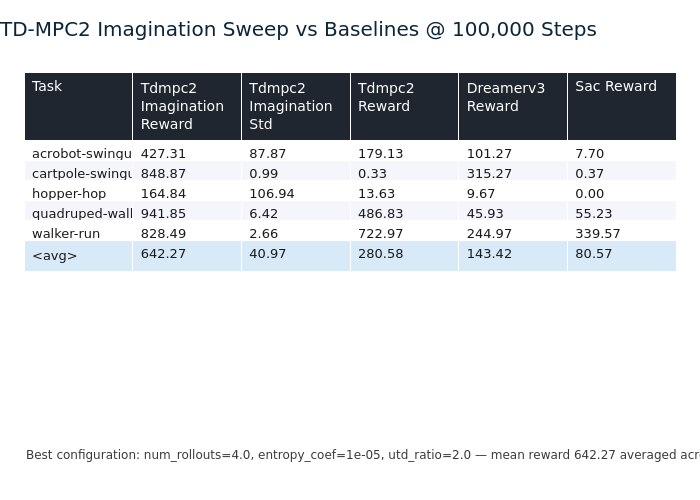

In [11]:
dreamerv3_df = baselines.load_many(evaluated_tasks, root=baselines.DREAMERV3_BASELINE_ROOT)
sac_df = baselines.load_many(evaluated_tasks, root=baselines.SAC_BASELINE_ROOT)

comparison_baselines = {
    BASELINE_LABEL: baseline_df,
    "dreamerv3": dreamerv3_df,
    "sac": sac_df,
}

comparison_df = selection.comparison_table(
    model_task_summary=best_result.task_summary,
    baselines=comparison_baselines,
    step_value=STEP_TARGET,
    model_label="tdmpc2-imagination",
)

comparison_csv = RESULTS_DIR / f"comparison_table_{STEP_TARGET}.csv"
comparison_df.to_csv(comparison_csv, index=False)

task_count = best_result.task_summary.shape[0]
footer_text = (
    f"Best configuration: {best_config_description} — mean reward "
    f"{best_config_mean_reward:.2f} averaged across {task_count} tasks."
 )

comparison_title = f"TD-MPC2 Imagination Sweep vs Baselines @ {STEP_TARGET:,} Steps"
comparison_fig = plotting.comparison_table_figure(
    comparison_df,
    title=comparison_title,
    footer_text=footer_text,
)
comparison_png = RESULTS_DIR / f"comparison_table_{STEP_TARGET}.png"
plotting.write_png(comparison_fig, output_path=comparison_png)
comparison_display = Image(filename=str(comparison_png))
comparison_display